In [1]:
# %pip install openai --quiet
# %pip install tenacity --quiet
# %pip install tqdm --quiet
# %pip install numpy --quiet
# %pip install typing --quiet
# %pip install tiktoken --quiet
# %pip install concurrent --quiet

In [44]:
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List
import Config


client = OpenAI(api_key = Config.openai_api_key)

GPT_MODEL = "gpt-4-vision-preview"
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013

In [19]:

styles_filepath = "small_data/archive_small_data/styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
Opened dataset successfully. Dataset has 44424 items of clothing.


In [22]:

import shutil
import os



# Select all or the first 1000 rows 
data = styles_df#.head(1000)

output_folder = 'selected_images'
os.makedirs(output_folder, exist_ok=True)

image_folder = 'small_data/archive_small_data/images/'
for index, row in data.iterrows():
    image_id = row['id']
    image_path = os.path.join(image_folder, f'{image_id}.jpg')
    
    if os.path.exists(image_path):
        shutil.copy(image_path, output_folder)
    else:
        print(f"Image file not found for ID: {image_id}. Skipping...")

output_csv = 'selected_styles.csv'
data.to_csv(output_csv, index=False)

print("Selected images and styles saved successfully.")


Image file not found for ID: 39403. Skipping...
Image file not found for ID: 39410. Skipping...
Image file not found for ID: 39401. Skipping...
Image file not found for ID: 39425. Skipping...
Image file not found for ID: 12347. Skipping...
Selected images and styles saved successfully.


In [23]:

styles_filepath = "selected_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
Opened dataset successfully. Dataset has 44424 items of clothing.


In [24]:
## Embedding Logic

@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: List):
    response = client.embeddings.create(
        input=input,
        model=EMBEDDING_MODEL
    ).data
    return [data.embedding for data in response]


def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]
     

# Function for batching and parallel processing the embeddings
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base")
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        
        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(encoded_corpus, batch_size)
        ]

        with tqdm(total=len(encoded_corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings
    


def generate_embeddings(df, column_name):
    descriptions = df[column_name].astype(str).tolist()
    embeddings = embed_corpus(descriptions)

    df['embeddings'] = embeddings
    print("Embeddings created successfully.")

In [25]:
generate_embeddings(styles_df, 'productDisplayName')
print("Writing embeddings to file ...")
styles_df.to_csv('sample_styles_with_embeddings.csv', index=False)
print("Embeddings successfully stored in sample_styles_with_embeddings.csv")

num_articles=44424, num_tokens=374172, est_embedding_cost=0.05 USD


44480it [03:48, 194.40it/s]                                                                                            


Embeddings created successfully.
Writing embeddings to file ...
Embeddings successfully stored in sample_styles_with_embeddings.csv


In [26]:
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                                          embeddings  
0  [-0.04859153553843498, 0.007310436572879553, -...  
1  [-0.03899

In [27]:
#Cosine Similarity Logic
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""
    
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]
    
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]
    
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    return sorted_indices

In [28]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""
   
   embeddings = df_items['embeddings'].tolist()

   
   similar_items = []
   for desc in item_descs:
      
      input_embedding = get_embeddings([desc])
    
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]
    
   return similar_items

In [29]:
def analyze_image(image_base64, subcategories):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender". 
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           The category needs to be chosen between the types in this list: {subcategories}.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.
                           
                           Example Input: An image representing a black leather jacket.

                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    features = response.choices[0].message.content
    return features

In [30]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

In [45]:
image_path = "selected_images/"
test_images = ["17534.jpg"]

reference_image = image_path + test_images[0]
encoded_image = encode_image_to_base64(reference_image)

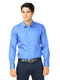

{'items': ["Men's Tailored Charcoal Grey Trousers", "Men's Black Leather Belt", "Men's Brown Oxford Shoes"], 'category': 'Shirts', 'gender': 'Men'}


In [46]:
unique_subcategories = styles_df['articleType'].unique()

analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

display(Image(filename=reference_image))
print(image_analysis)

In [47]:
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

matching_items = find_matching_items_with_rag(filtered_items, item_descs)

html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']
        
    image_path = os.path.join('selected_images', f'{item_id}.jpg')  
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

print(item_descs)
display(HTML(html))

21464 Remaining Items
["Men's Tailored Charcoal Grey Trousers", "Men's Black Leather Belt", "Men's Brown Oxford Shoes"]


In [48]:
def check_match(reference_image_base64, suggested_image_base64):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """ You will be given two images of two different items of clothing.
                            Your goal is to decide if the items in the images would work in an outfit together.
                            The first image is the reference item (the item that the user is trying to match with another item).
                            You need to decide if the second item would work well with the reference item.
                            Your response must be a JSON output with the following fields: "answer", "reason".
                            The "answer" field must be either "yes" or "no", depending on whether you think the items would work well together.
                            The "reason" field must be a short explanation of your reasoning for your decision. Do not include the descriptions of the 2 images.
                            Do not include the ```json ``` tag in the output.
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{reference_image_base64}",
                },
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{suggested_image_base64}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    features = response.choices[0].message.content
    return features

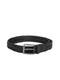

The items match!
A black belt usually pairs well with any color dress shirt for a professional or semi-formal outfit.


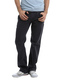

The items match!
The first item appears to be a dress shirt, typically in a color that works well for business casual or smart casual attire. The second item seems to be a pair of dark jeans. A dress shirt can pair nicely with dark jeans for a smart casual look, making them compatible for an outfit together.


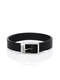

The items match!
A black belt with a silver buckle typically pairs well with most dress shirts for a professional or semi-formal look. The blue dress shirt would match well with the black belt.


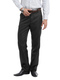

The items match!
The first item is a solid blue dress shirt which is a versatile piece that can be matched with various types of pants. The second item is a pair of black pants, which are also versatile and generally considered a wardrobe staple. Black pants and a blue shirt can be combined to create a formal or business casual outfit, so they would work well together.


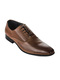

The items match!
The dress shirt is a versatile piece that typically pairs well with formal shoes. The color of the shoes is neutral and would complement a variety of shirt colors including the color of the reference shirt.


In [49]:
paths = list(set(paths))

for path in paths:
    suggested_image = encode_image_to_base64(path)
    
    match = json.loads(check_match(encoded_image, suggested_image))
    
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match["reason"])

In [40]:
image_path = "selected_images/"
test_images = ["8488.jpg"]

reference_image = image_path + test_images[0]
encoded_image = encode_image_to_base64(reference_image)

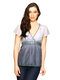

{'items': ["Light Blue Women's Denim Jeans", "Tan Leather Women's Satchel", "White Women's Casual Sneakers"], 'category': 'Tops', 'gender': 'Women'}


In [41]:
unique_subcategories = styles_df['articleType'].unique()

analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)

display(Image(filename=reference_image))
print(image_analysis)

In [42]:
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

matching_items = find_matching_items_with_rag(filtered_items, item_descs)

html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']
        
    image_path = os.path.join('selected_images', f'{item_id}.jpg')  
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

print(item_descs)
display(HTML(html))

19260 Remaining Items
["Light Blue Women's Denim Jeans", "Tan Leather Women's Satchel", "White Women's Casual Sneakers"]


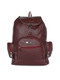

The items match!
The two items can work together in an outfit because they are different types of items (a top and a backpack) and thus do not need to match exactly. As long as the colors do not clash, which they don't in this case, they can be considered complementary.


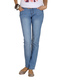

The items match!
The two items are both casual pieces with a similar color palette, making them complementary for a casual outfit.


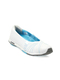

The items match!
The items could potentially work together. The top is a casual blouse with a comfortable look while the shoes are casual flats. Both items appear to be in a relaxed style, making them a feasible pairing for a casual outfit.


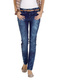

The items match!
The items appear to be a casual top and a pair of jeans, which are typically compatible and would likely form a coherent casual outfit.


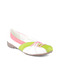

The items match!
The colors of the second item are soft and neutral, which tend to pair easily with a variety of tops. Given that the reference item is also soft in coloration and simple in design, these two items can complement each other in an outfit.


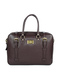

The items match!
The first item is a casual style top, and the second item is a handbag. Handbags can complement a wide range of outfits, and there is nothing about the color or style of the bag that particularly clashes with the top. They could work well together in an outfit.


In [43]:
paths = list(set(paths))

for path in paths:
    suggested_image = encode_image_to_base64(path)
    
    match = json.loads(check_match(encoded_image, suggested_image))
    
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("The items match!")
        print(match["reason"])